In [16]:
# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# =========================================================
# Funtions
# =========================================================

def read_raw_data_as_pandas_df(raw_data_file_path):

    # Read file with timestamp as index
    precip = pd.read_csv(raw_data_file_path, encoding="ISO-8859-1",index_col=1)

    # Timestamps str -> datetime
    precip.index = pd.to_datetime(precip.index)

    # Save ID of station
    station_id = str(precip.station.iloc[0])

    # Remove column with station ID
    precip = precip.drop("station",axis=1) 

    return precip,station_id

class precip_time_series:
    def __init__(self, data_path):
        self.data,self.statid = self.read_raw_data_as_pandas_df(data_path)
        self.events = []
    
    def read_raw_data_as_pandas_df(self,raw_data_file_path):
        # Read file with timestamp as index
        precip = pd.read_csv(raw_data_file_path, encoding="ISO-8859-1",index_col=1)

        # Timestamps str -> datetime
        precip.index = pd.to_datetime(precip.index)

        # Save ID of station
        station_id = str(precip.station.iloc[0])

        # Remove column with station ID
        precip = precip.drop("station",axis=1)
        
        return precip,station_id

    def pad_and_resample(self,freq = '5min',pad_value = 0):
        # Resample the data to the specified frequency and pad missing values with pad_value
        self.data = self.data.resample(freq).sum().fillna(pad_value)

    def get_events(self,threshold='11h',min_duration = 30, min_precip = 1):
        
        self.init_events(threshold)
        self.filter_events_by_length(min_duration)
        self.filter_events_by_amount(min_precip)

    def init_events(self,threshold):
        
        precip = self.data
        
        # Size of timesteps
        time_delta = precip.index[1]-precip.index[0]

        # Rolling 11 hour sum
        precip_sum = precip.rolling(threshold).sum()

        # dates with no precip last 11 hours
        dates_w_zero_sum = precip_sum.index[(precip_sum.mask(precip_sum!=0)==precip_sum).values[:,0]]

        # Add first date with rain
        for date in precip.index:
            if precip.loc[date].values[0] != 0:
                start_dates = [date]
                break

        # Save start and end dates
        end_dates   = []
        for date in tqdm(dates_w_zero_sum):
            if precip_sum.loc[date- time_delta].values[0]!=0:
                end_dates += [date- pd.to_timedelta(threshold)]
            if precip_sum.loc[date+ time_delta].values[0]!=0:
                start_dates += [date+ time_delta]
        
        # Add end to last event
        for date in reversed(precip.index):  # Iterate from last to first
            if precip.loc[date].values[0] != 0:  # Check if value is not zero
                end_dates += [date]
                break  # Stop at the first nonzero value
        
        # Save events as list of tuples
        events = []
        for i in range(len(end_dates)):
            events+=[(start_dates[i],end_dates[i])]

        # update events
        self.events = events

    def filter_events_by_length(self,min_duration):
        
        # Remove events with duration under min duration
        filtered_events = [event for event in self.events if event[1]-event[0]>=pd.Timedelta(minutes=min_duration)]

        # Update events
        self.events = filtered_events
    
    def filter_events_by_amount(self,min_precip):
        
        # Remove events with total precip under minimum
        filtered_events = [event for event in self.events if self.data.loc[event[0]:event[1]].sum().values[0]>=min_precip]
        
        # update events
        self.events = filtered_events

    def plot_all_events(self):
        plt.figure()
        plt.plot(self.data.index,self.data.values)
        for i,dates in enumerate(self.events):
            plt.vlines(dates[0],colors="green",linestyles='--',ymin=0,ymax=3)
            plt.vlines(dates[1],colors="red",linestyles='--',ymin=0,ymax=3)
        plt.legend(["Precipitation","Event start","Event end"])
        plt.ylabel("[mm]")
        plt.title("Padded precip data, with events")

    def plot_secific_event(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1]-self.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        plt.figure()
        event = (self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]])

        # plot were right edge align w timestamp
        plt.bar(event.index-time_delta,event.values[:,0],width=pd.Timedelta(minutes=time_delta_minuts),align="edge")

        plt.legend(["Precipitation"])
        plt.title(f"Event {event_idx}")

    def plot_secific_event_w_hist(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1] - self.data.index[0]
        time_delta_minutes = time_delta.seconds / 60

        # Extract event data
        event = self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]]

        # Create a figure with two subplots (1 row, 2 columns)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # **Plot time series (left subplot)**
        axes[0].bar(event.index - time_delta, event.values[:, 0], 
                    width=pd.Timedelta(minutes=time_delta_minutes), align="edge")
        axes[0].set_title(f"Event {event_idx}")
        axes[0].set_ylabel("Precipitation (mm)")
        axes[0].set_xlabel("Time")
        axes[0].legend(["Precipitation"])

        # **Plot histogram (right subplot)**
        axes[1].hist(event.values[:, 0], bins=10, edgecolor='black', alpha=0.7)
        axes[1].set_title("Precipitation Histogram")
        axes[1].set_xlabel("Precipitation (mm)")
        axes[1].set_ylabel("Frequency")

        # Adjust layout for clarity
        plt.tight_layout()
        
        
    def return_specific_event(self,event_idx):

        # Size of timesteps
        time_delta = self.data.index[1] - self.data.index[0]
        time_delta_minutes = time_delta.seconds / 60

        # Extract event data
        event = self.data.loc[self.events[event_idx][0]:self.events[event_idx][1]]

        return event

class rainfall_analysis:
    def __init__(self,ts: precip_time_series):
        self.ts = ts
        self.metrics = {} 

    def compute_intermittency(self,series):
            
            total_timesteps = len(series)
            wet = series>0
            transistions = (wet[:-1] != wet[1:]).sum()
            
            intermittency = transistions/total_timesteps
    
            return intermittency 

    def compute_rcg_idx(self,series):
            
            # Culmitative sum
            culmitative_sum = np.cumsum(series)
            
            # Normalize
            culmitative_sum /= culmitative_sum[-1]

            #first idx over 0.5
            idx = np.argmax(culmitative_sum>0.5)

            return idx

    def compute_rcg(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        rcg_indeces = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[rcg_indeces[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)

        # rcg
        rcg = tcg/self.metrics["duration"]

        return rcg

    def compute_mass_dist_indicators(self,series):

        """
        Thoughts:
        Current implementation treats time as discrete, alternatively one could use averages if 
        0.33*T is not a multiple of stepsize.
        """
        # length of series
        steps = len(series)

        # peak_idx
        peak_idx = np.argmax(series)

        # Culmitative sum
        culmitative_sum = np.cumsum(series)

        # Mass distribution indicators
        if peak_idx == 0:
            m1   = culmitative_sum[peak_idx]/culmitative_sum[-1]
        else:
            m1   = culmitative_sum[peak_idx]/(culmitative_sum[-1]-culmitative_sum[peak_idx-1])
        
        m2   = (series[peak_idx]/culmitative_sum[-1])[0]
        m3   = culmitative_sum[np.int32(np.round(steps/3))-1]/culmitative_sum[-1]
        m4   = culmitative_sum[np.int32(np.round(steps*0.3))-1]/culmitative_sum[-1]
        m5   = culmitative_sum[np.int32(np.round(steps/2))-1]/culmitative_sum[-1]    

        return np.array([m1,m2,m3,m4,m5])

    def compute_time_based_skewness(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        CoM_idx = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[CoM_idx[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)
        
        time_based_skewness_list = np.zeros(tcg.shape)

        for i, event in enumerate(self.ts.events):
            series = self.ts.data.loc[event[0]:event[1]].values

            numerator = np.array([((j+1)*time_delta_minuts-tcg[i])**3 * precip for j,precip in enumerate(series)]).sum()

            total_precip = series.sum()

            sigma_t = np.sqrt(np.array([((j+1)*time_delta_minuts-tcg[i])**2 * precip for j,precip in enumerate(series)]).sum()/total_precip)

            time_based_skewness_list[i] = numerator/(total_precip*sigma_t**3)

        
        return time_based_skewness_list

    def compute_time_based_kurtosis(self):

        time_delta = self.ts.data.index[1]-self.ts.data.index[0]
        time_delta_minuts = time_delta.seconds/60

        # first index over center of mass
        CoM_idx = np.array([self.compute_rcg_idx(self.ts.data.loc[event[0]:event[1]].values) for event in self.ts.events])

        # time of center
        toc = np.array([self.ts.data.loc[event[0]:event[1]].index[CoM_idx[i]] for i,event in enumerate(self.ts.events)])

        # duration until center
        tcg = np.array([time_delta_minuts + (toc[i] - event[0]).total_seconds()/60 for i,event in enumerate(self.ts.events)]).reshape(self.metrics["duration"].shape)
        
        time_based_kurtosis_list = np.zeros(tcg.shape)

        for i, event in enumerate(self.ts.events):
            series = self.ts.data.loc[event[0]:event[1]].values

            numerator = np.array([((j+1)*time_delta_minuts-tcg[i])**4 * precip for j,precip in enumerate(series)]).sum()

            total_precip = series.sum()

            sigma_t = np.sqrt(np.array([((j+1)*time_delta_minuts-tcg[i])**2 * precip for j,precip in enumerate(series)]).sum()/total_precip)

            time_based_kurtosis_list[i] = numerator/(total_precip*sigma_t**4)

        
        return time_based_kurtosis_list
        
    def get_metrics(self):

        padded_precip = self.ts.data
        events_list = self.ts.events

        # resolution    
        time_delta = padded_precip.index[1]-padded_precip.index[0]
        time_delta_minuts = time_delta.seconds/60

        # Max intensity [mm/min]
        self.metrics["max_intensity"] = np.array([padded_precip.loc[event[0]:event[1]].max().values[0] for event in events_list])/time_delta_minuts
        
        # Mean intensity [mm/min]
        self.metrics["mean_intensity"] = np.array([padded_precip.loc[event[0]:event[1]].mean().values[0] for event in events_list])/time_delta_minuts

        # Peak to mean ratio 
        self.metrics["pmr"] = self.metrics["max_intensity"]/self.metrics["mean_intensity"]

        # Time to peak intensity [min]
        self.metrics["ttp"] = np.array([time_delta_minuts+np.float32((padded_precip.loc[event[0]:event[1]].idxmax()-event[0]).values/(60*10**9)) for event in events_list]) 

        # Duration [min]
        self.metrics["duration"] = np.array([time_delta_minuts+(event[1]-event[0]).days*24*60+(event[1]-event[0]).seconds/60 for event in events_list]).reshape(self.metrics["ttp"].shape)
        
        # Rainfall peak coefficient
        #TODO

        # Sum of precipiation [mm]
        self.metrics["total_precip"] = np.array([padded_precip.loc[event[0]:event[1]].sum().values[0] for event in events_list])

        # Standard deviation [mm/min]
        self.metrics["std"] = np.array([padded_precip.loc[event[0]:event[1]].std().values[0] for event in events_list])/np.square(time_delta_minuts)
        
        # Number of wet/dry times - intermittency
        self.metrics["intermittency"] = np.array([[self.compute_intermittency(padded_precip.loc[event[0]:event[1]].values)] for event in events_list])

        # Skewness
        self.metrics["skewness"] = np.array([padded_precip.loc[event[0]:event[1]].skew().values[0] for event in events_list])

        # Kurtosis
        self.metrics["kurtosis"] = np.array([padded_precip.loc[event[0]:event[1]].kurtosis().values[0] for event in events_list])

        # Peak position reatio (r)
        self.metrics["ppr"] = self.metrics["ttp"]/self.metrics["duration"]

        # Centre of Gravity Position Indicator (rcg)
        self.metrics["rcg"] = self.compute_rcg()

        # Mass distribution indicators shape: #event rows and 5 columns for (m1..m5). 
        temp = np.array([self.compute_mass_dist_indicators(padded_precip.loc[event[0]:event[1]].values) for event in events_list])
        self.metrics["m1"] = temp[:,0]
        self.metrics["m2"] = temp[:,1]
        self.metrics["m3"] = temp[:,2]
        self.metrics["m4"] = temp[:,3]
        self.metrics["m5"] = temp[:,4]

        # Rainfall Intensity Irregularity (ni)
        self.metrics["ni"] = np.array([padded_precip.loc[event[0]:event[1]].max().values[0]/padded_precip.loc[event[0]:event[1]].mean().values[0]for event in events_list])

        # I30
        self.metrics["I30"] = np.array([padded_precip.loc[event[0]:event[1]].rolling(window="30min").sum().max().values[0] for event in events_list])/30

        # Time based skewness
        self.metrics["time_based_skewness"] = self.compute_time_based_skewness()

        # Time based kurtosis
        self.metrics["time_based_kurtosis"] = self.compute_time_based_kurtosis()

    def plot_boxplots(self, metrics):
        n_plots = len(metrics)
        cols = min(n_plots, 4)  # Max 4 columns
        rows = np.int16(np.ceil(n_plots / 4))  # Determine number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Create subplots grid
        axes = np.ravel(axes)  # Flatten to 1D for easy iteration

        for i, metric in enumerate(metrics):
            axes[i].boxplot(self.metrics[metric])  # Use correct subplot
            axes[i].set_title(metric)

        plt.tight_layout()  # Adjust layout for clarity
    
    def plot_histograms(self,metrics):
        
        n_plots = len(metrics)
        cols = min(n_plots, 4)  # Max 4 columns
        rows = np.int16(np.ceil(n_plots / 4))  # Determine number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Create subplots grid
        axes = np.ravel(axes)  # Flatten to 1D for easy iteration

        for i, metric in enumerate(metrics):
            axes[i].hist(self.metrics[metric])  # Use correct subplot
            axes[i].set_title(metric)

        plt.tight_layout()  # Adjust layout for clarity


In [2]:
# =========================================================
# Input
# =========================================================

# Path to data file
raw_data_file =  "/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/Sample1.csv"

# =========================================================
# Script
# =========================================================

# Load ts
ts = precip_time_series(raw_data_file)

# pad and resample 
ts.pad_and_resample()

# Get filtered events
ts.get_events()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25604/25604 [00:07<00:00, 3603.14it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25604/25604 [00:06<00:00, 3666.32it/s]


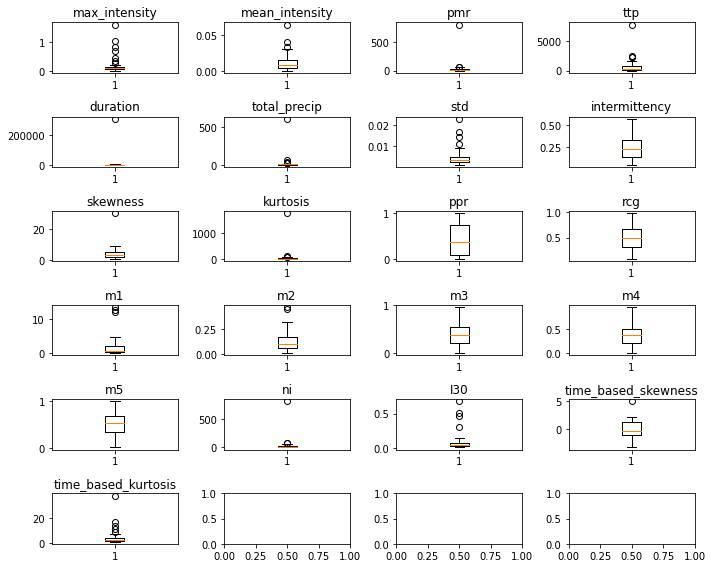

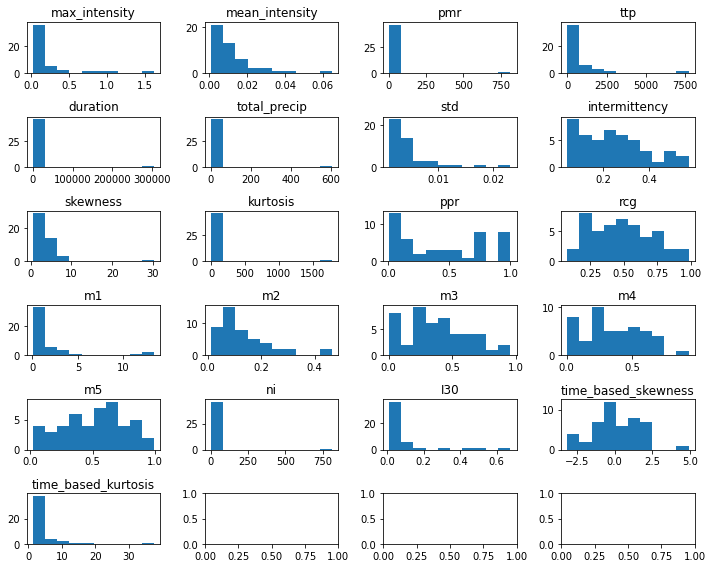

In [19]:
# =========================================================
# Input
# =========================================================

# Path to data file
raw_data_file =  "/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/Sample1.csv"

# =========================================================
# Script
# =========================================================

# Load ts
ts = precip_time_series(raw_data_file)

# pad and resample 
ts.pad_and_resample()

# Get filtered events
ts.get_events()

# Analysis
analysis = rainfall_analysis(ts)
analysis.get_metrics()

# Plots
#ts.plot_all_events()
#ts.plot_secific_event_w_hist(event_idx=0)
#ts.plot_secific_event_w_hist(event_idx=1)
#ts.plot_secific_event_w_hist(event_idx=3)
#ts.plot_secific_event_w_hist(event_idx=4)
#print(f"skewness: {analysis.metrics["skewness"][:4]}")
#print(f"time based skewness: {analysis.metrics["time_based_skewness"][:4]}")

analysis.plot_boxplots(analysis.metrics.keys())
analysis.plot_histograms(analysis.metrics.keys())
plt.show()


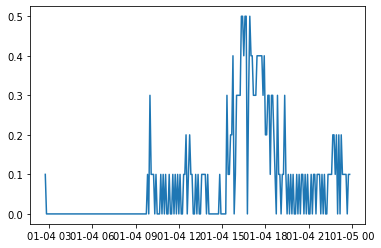

In [30]:
event1 = ts.return_specific_event(event_idx=1)
plt.plot(event1)

In [1]:
# event1.rename({"Nedbør (mm)": 'Precipitation (mm)'})